In [5]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

## Coherence

In [7]:
# Read coherence files and append all to data frame
path = "../data/bids/derivatives/coherence/*_coh*"
coh = pd.DataFrame()
for fpath in glob.glob(path):
    data = pd.read_pickle(fpath)
    coh = pd.concat([coh, data])
coh = coh.set_index('index')

In [9]:
coh

,sub,cond,chan,50,100,150,200,250
index,,,,,,,,
0,20,50,1,0.147185,0.036000,0.039417,0.044433,0.016864
1,20,50,2,0.191859,0.065636,0.039113,0.038524,0.018004
2,20,50,3,0.054490,0.027235,0.032155,0.031661,0.013006
3,20,50,4,0.084261,0.054827,0.011647,0.037445,0.034014
4,20,50,5,0.058588,0.038144,0.015845,0.038893,0.046590
...,...,...,...,...,...,...,...,...
57,22,250,58,0.039263,0.043022,0.011552,0.028578,0.319057
58,22,250,59,0.018490,0.039236,0.038128,0.038204,0.080147
59,22,250,60,0.079515,0.053140,0.029179,0.030722,0.096466


In [11]:
# Average across channels
coh_chan_avg = coh.groupby(['sub', 'cond']).mean()
coh_chan_avg = coh_chan_avg.drop(columns = ['chan'])
coh_chan_avg = coh_chan_avg.reset_index()

# Average across subjects for barplot
coh_sub_avgs = coh_chan_avg.groupby(['cond']).mean()
indexes = pd.Series([2, 3, 4, 5, 1])
coh_sub_avgs = coh_sub_avgs.set_index(indexes)
coh_sub_avgs = coh_sub_avgs.sort_index(ascending=True)
coh_sub_avgs

# Calculate standard deviation
stds = coh_chan_avg.groupby(['cond']).std()
stds = stds.set_index(indexes)
stds = stds.sort_index(ascending=True)
stds

,50,100,150,200,250
1,0.053795,0.011405,0.006537,0.006279,0.007122
2,0.007234,0.036695,0.006524,0.010386,0.007423
3,0.009269,0.006896,0.054939,0.007678,0.008416
4,0.007924,0.007512,0.007211,0.053910,0.007517
5,0.008889,0.006692,0.007447,0.006868,0.071806


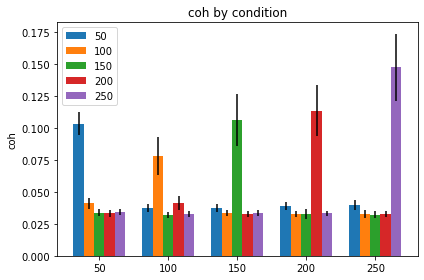

<Figure size 432x288 with 0 Axes>

In [30]:
# Plot grouped bar chart
fig, ax = plt.subplots()
labels = ['50', '100', '150', '200', '250']

x = np.arange(len(labels))
width = 0.15

rect1 = ax.bar(x - width*2, coh_sub_avgs['50'], yerr = stds['50'], width = width, label = '50')
rect2 = ax.bar(x - width*1, coh_sub_avgs['100'], yerr = stds['100'], width = width, label = '100')
rect3 = ax.bar(x + width*0, coh_sub_avgs['150'], yerr = stds['150'], width = width, label = '150')
rect4 = ax.bar(x + width*1, coh_sub_avgs['200'], yerr = stds['200'], width = width, label = '200')
rect5 = ax.bar(x + width*2, coh_sub_avgs['250'], yerr = stds['250'], width = width, label = '250')

# Add some labels
ax.set_ylabel('coh')
ax.set_title('coh by condition')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()
plt.savefig('../figs/coherence.png', dpi = 600)

#### Boxplots with seaborn

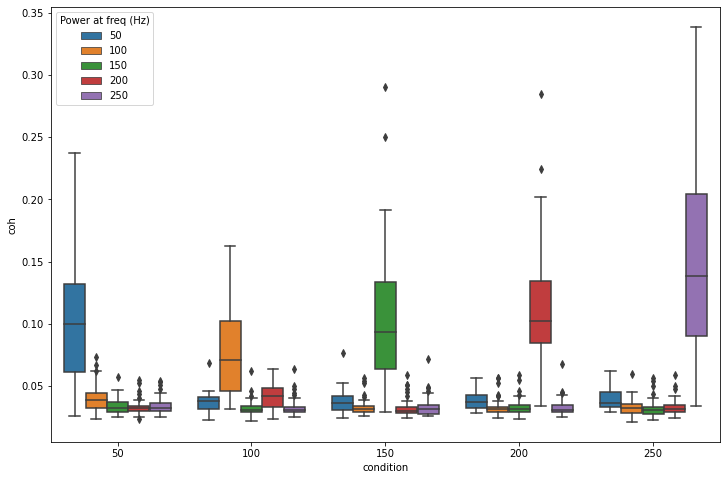

In [41]:
# Pivot into tidy
coh_tidy = coh_chan_avg
coh_tidy["condition"] = pd.to_numeric(coh_tidy["cond"])
coh_tidy = pd.melt(coh_tidy, 
                     id_vars = ['sub', 'condition'], 
                     value_vars=['50', '100', '150', '200', '250'],
                     var_name = 'power_at_freq',
                     value_name = 'coh')

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(x = "condition", 
                 y = "coh", 
                 hue = "power_at_freq", 
                 data = coh_tidy,
                 ax = ax)
ax = ax.legend(title='Power at freq (Hz)', loc='upper left')

# Save
fig = ax.get_figure()
fig.savefig('../figs/coherence_seaborn.png', dpi = 600)

#### ANOVA

In [17]:
# Subset by condition
coh_50 = coh_chan_avg[coh_chan_avg['cond'] == 50]
coh_100 = coh_chan_avg[coh_chan_avg['cond'] == 100]
coh_150 = coh_chan_avg[coh_chan_avg['cond'] == 150]
coh_200 = coh_chan_avg[coh_chan_avg['cond'] == 200]
coh_250 = coh_chan_avg[coh_chan_avg['cond'] == 250]

# Compute ANOVA by condition
f_50, p_50 = f_oneway(coh_50['50'], coh_50['100'], coh_50['150'], coh_50['200'], coh_50['250'])
f_100, p_100 = f_oneway(coh_100['50'], coh_100['100'], coh_100['150'], coh_100['200'], coh_100['250'])
f_150, p_150 = f_oneway(coh_150['50'], coh_150['100'], coh_150['150'], coh_150['200'], coh_150['250'])
f_200, p_200 = f_oneway(coh_200['50'], coh_200['100'], coh_200['150'], coh_200['200'], coh_200['250'])
f_250, p_250 = f_oneway(coh_250['50'], coh_250['100'], coh_250['150'], coh_250['200'], coh_250['250'])

# Print p-values
print(f"ANOVA for coherence differences at 50 Hz:, f = {f_50}, p = {p_50}")
print(f"ANOVA for coherence differences at 50 Hz:, f = {f_100}, p = {p_100}")
print(f"ANOVA for coherence differences at 50 Hz:, f = {f_150}, p = {p_150}")
print(f"ANOVA for coherence differences at 50 Hz:, f = {f_200}, p = {p_200}")
print(f"ANOVA for coherence differences at 50 Hz:, f = {f_250}, p = {p_250}")

ANOVA for coherence differences at 50 Hz:, f = 61.755189726805156, p = 3.6059576154400152e-34
ANOVA for coherence differences at 50 Hz:, f = 48.398981368095555, p = 1.2760788698811942e-28
ANOVA for coherence differences at 50 Hz:, f = 66.0914387290908, p = 7.829392669770477e-36
ANOVA for coherence differences at 50 Hz:, f = 84.22980910449793, p = 3.447901438953521e-42
ANOVA for coherence differences at 50 Hz:, f = 100.15743335964837, p = 4.131921608774431e-47


## Imaginary coherence

In [19]:
# Read coherence files and append all to data frame
path = "../data/bids/derivatives/coherence/*_imcoh*"
imcoh = pd.DataFrame()
for fpath in glob.glob(path):
    data = pd.read_pickle(fpath)
    imcoh = pd.concat([imcoh, data])
imcoh = imcoh.set_index('index')

In [21]:
imcoh

,sub,cond,chan,50,100,150,200,250
index,,,,,,,,
0,26,50,1,0.035015,-0.010264,0.034303,0.004957,-0.017542
1,26,50,2,-0.007696,-0.005978,-0.035957,0.042219,0.016749
2,26,50,3,-0.056433,-0.033334,0.013716,-0.020167,-0.000977
3,26,50,4,0.053946,0.013519,0.002770,0.028147,-0.022476
4,26,50,5,0.028113,-0.030932,0.017950,0.014004,-0.007850
...,...,...,...,...,...,...,...,...
57,13,250,58,-0.037800,-0.001848,0.008189,0.012494,-0.011101
58,13,250,59,0.042989,-0.023683,0.014755,0.014768,-0.041642
59,13,250,60,-0.008271,-0.025821,0.036905,-0.002460,0.012335


In [23]:
# Average across channels
imcoh_chan_avg = imcoh.groupby(['sub', 'cond']).mean()
imcoh_chan_avg = imcoh_chan_avg.drop(columns = ['chan'])
imcoh_chan_avg = imcoh_chan_avg.reset_index()

# Average across subjects for barplot
imcoh_sub_avgs = imcoh_chan_avg.groupby(['cond']).mean()
indexes = pd.Series([2, 3, 4, 5, 1])
imcoh_sub_avgs = imcoh_sub_avgs.set_index(indexes)
imcoh_sub_avgs = imcoh_sub_avgs.sort_index(ascending=True)
print(imcoh_sub_avgs)

# Calculate standard deviation
stds = imcoh_chan_avg.groupby(['cond']).std()
stds = stds.set_index(indexes)
stds = stds.sort_index(ascending=True)
print(stds)

         50       100       150       200       250
1 -0.004213  0.002450 -0.000965  0.000332  0.000090
2  0.000329 -0.000734  0.000336 -0.002510  0.000024
3 -0.001328  0.000318 -0.006678  0.000937  0.000026
4  0.000609 -0.000048 -0.000540  0.006047 -0.000575
5 -0.000493  0.000058  0.000941  0.000298  0.016094
         50       100       150       200       250
1  0.009078  0.004519  0.002516  0.002840  0.002284
2  0.003133  0.014728  0.002403  0.005635  0.002000
3  0.003417  0.002452  0.020340  0.002148  0.002239
4  0.002892  0.002366  0.003736  0.020127  0.001882
5  0.003984  0.003153  0.002906  0.002322  0.026311


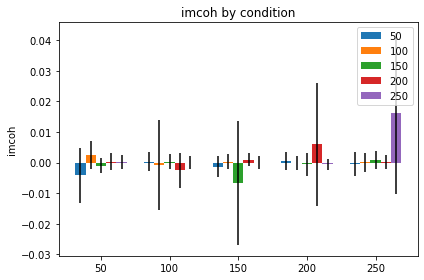

In [24]:
# Plot grouped bar chart
fig, ax = plt.subplots()
labels = ['50', '100', '150', '200', '250']

x = np.arange(len(labels))
width = 0.15

rect1 = ax.bar(x - width*2, imcoh_sub_avgs['50'], yerr = stds['50'], width = width, label = '50')
rect2 = ax.bar(x - width*1, imcoh_sub_avgs['100'], yerr = stds['100'], width = width, label = '100')
rect3 = ax.bar(x + width*0, imcoh_sub_avgs['150'], yerr = stds['150'], width = width, label = '150')
rect4 = ax.bar(x + width*1, imcoh_sub_avgs['200'], yerr = stds['200'], width = width, label = '200')
rect5 = ax.bar(x + width*2, imcoh_sub_avgs['250'], yerr = stds['250'], width = width, label = '250')

# Add some labels
ax.set_ylabel('imcoh')
ax.set_title('imcoh by condition')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

#### Boxplots with seaborn

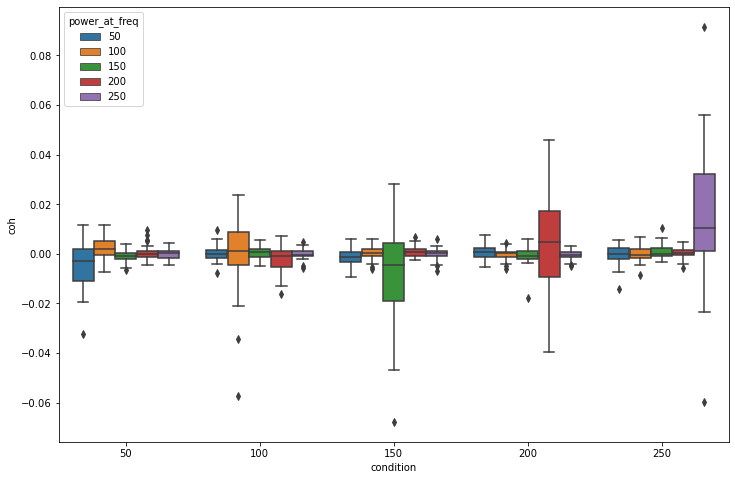

In [42]:
# Pivot into tidy
imcoh_tidy = imcoh_chan_avg
imcoh_tidy["condition"] = pd.to_numeric(imcoh_tidy["cond"])
imcoh_tidy = pd.melt(imcoh_tidy, 
                     id_vars = ['sub', 'condition'], 
                     value_vars=['50', '100', '150', '200', '250'],
                     var_name = 'power_at_freq',
                     value_name = 'coh')

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(x = "condition", 
                 y = "coh", 
                 hue = "power_at_freq", 
                 data = imcoh_tidy,
                 ax = ax)

# Save
fig = ax.get_figure()
fig.savefig('../figs/imaginary_coherence_seaborn.png', dpi = 600)

#### ANOVA

In [26]:
# Subset by condition
imcoh_50 = imcoh_chan_avg[imcoh_chan_avg['cond'] == 50]
imcoh_100 = imcoh_chan_avg[imcoh_chan_avg['cond'] == 100]
imcoh_150 = imcoh_chan_avg[imcoh_chan_avg['cond'] == 150]
imcoh_200 = imcoh_chan_avg[imcoh_chan_avg['cond'] == 200]
imcoh_250 = imcoh_chan_avg[imcoh_chan_avg['cond'] == 250]

# Compute ANOVA by condition
f_50, p_50 = f_oneway(imcoh_50['50'], imcoh_50['100'], imcoh_50['150'], imcoh_50['200'], imcoh_50['250'])
f_100, p_100 = f_oneway(imcoh_100['50'], imcoh_100['100'], imcoh_100['150'], imcoh_100['200'], imcoh_100['250'])
f_150, p_150 = f_oneway(imcoh_150['50'], imcoh_150['100'], imcoh_150['150'], imcoh_150['200'], imcoh_150['250'])
f_200, p_200 = f_oneway(imcoh_200['50'], imcoh_200['100'], imcoh_200['150'], imcoh_200['200'], imcoh_200['250'])
f_250, p_250 = f_oneway(imcoh_250['50'], imcoh_250['100'], imcoh_250['150'], imcoh_250['200'], imcoh_250['250'])

# Print p-values
print(f"ANOVA for imcoherence differences at 50 Hz:, f = {f_50}, p = {p_50}")
print(f"ANOVA for imcoherence differences at 50 Hz:, f = {f_100}, p = {p_100}")
print(f"ANOVA for imcoherence differences at 50 Hz:, f = {f_150}, p = {p_150}")
print(f"ANOVA for imcoherence differences at 50 Hz:, f = {f_200}, p = {p_200}")
print(f"ANOVA for imcoherence differences at 50 Hz:, f = {f_250}, p = {p_250}")

ANOVA for imcoherence differences at 50 Hz:, f = 9.692117746733457, p = 3.601672239904822e-07
ANOVA for imcoherence differences at 50 Hz:, f = 1.0723468743452533, p = 0.3713845844380826
ANOVA for imcoherence differences at 50 Hz:, f = 4.341844827295563, p = 0.00218915789405912
ANOVA for imcoherence differences at 50 Hz:, f = 3.6108523671028125, p = 0.00728108752961126
ANOVA for imcoherence differences at 50 Hz:, f = 13.876998682555802, p = 5.590607854320032e-10
